As the model itself is 

# INIT

In [7]:
!pip install numpy
!pip install librosa
!pip install pretty_midi
!pip install pandas
!pip install matplotlib
!pip install torch
!pip install sounddevice



In [16]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
#custom functions
import dataload2 as dl
from settings import Settings
from Helperfunctions import sigmoid
import midi
import model

In [50]:

settings = Settings()

settings.playSampleTime = 5
settings.diminishedSet = True
settings.diminishFactor = 10

printPlots = settings.printPlots
playSample = settings.playSample
forceCPU = settings.forceCPU
batchSize = settings.hyperparameters['batchSize']
useSavedNet = settings.useSavedNet
useCheckpoints = settings.useCheckpoints
playSampleTime = settings.playSampleTime
diminishedSet = settings.diminishedSet

useCuda,device = model.getDevice(forceCPU=forceCPU)
print("Cuda available: ",useCuda,' device:', device,'\n')
if( not useCuda):
    settings.lowMemory = False
if(settings.lowMemory):
    print("Using lowMemory settings")
    print("Autoscaling of loss and variables enabled")
training,test,validation = dl.createMaestroDatasets(diminishedSet=diminishedSet)
dataloaderTrain = DataLoader(training,batch_size=batchSize, shuffle=True)
dataloaderValidation = DataLoader(validation,batch_size=batchSize, shuffle=True)
dataloaderTest = DataLoader(test,batch_size=batchSize, shuffle=True)


hello 

Cuda available:  False  device: cpu 

createMaestroDatasets: Found CSV file
Searched for midi files in:  Dataset/maestro-v2.0.0/**/
Found  1282  of  1282  midi files
967 midi files found with split 'train'
178 midi files found with split 'test'
137 midi files found with split 'validation'
Diminished dataset enabled with factor 10
Diminished trainset with 97 first midi files created
Diminished testset with 18 first midi files created
Diminished validationset with 14 first midi files created 



## test datasets

In [51]:
#Load 1. sample and check it
sampleInput,sampleTarget,samplefs = training[0]
print("printing shapes of a pianoRoll. Expected is [Nx128], as there is 128 midi notes, and length varies")
print("example shape: ", sampleInput.shape)

printing shapes of a pianoRoll. Expected is [Nx128], as there is 128 midi notes, and length varies
example shape:  (1440, 128)


# Test midi functions

## Plot piano rolls of input and target

Not much difference to see due to the shift of only 1 step

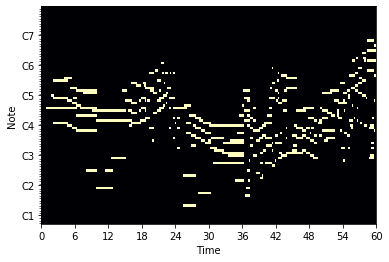

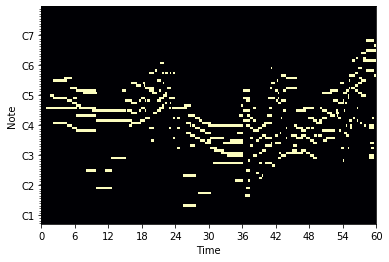

<Figure size 8000x6400 with 0 Axes>

In [52]:
    midi.plotPianoRoll(sampleInput,fs=samplefs)
    plt.figure(num=1,figsize=(10,8),dpi=800)
    plt.show()
    midi.plotPianoRoll(sampleTarget,fs=samplefs)
    plt.figure(figsize=(10,8),dpi=800)
    plt.show()
    

In [48]:
#verify target creation this way instead
tmp = np.zeros((50,128))
tmp[25,100] = 1
tmpInput,tmpTarget = dl.createInputsTargetsFromPianoRoll(tmp)
assert(( tmpTarget[24,:] == tmpInput[25,:]).all())

## play short sample of input

In [53]:
    midi.playPianoRoll(sampleInput,fs=samplefs,playTime=playSampleTime)

midi:playPianoRoll: no Fluidsynth installed. Synthesizing using sine waves


# Load saved network and test it

In [54]:
    print('Using saved net: ',settings.savedNetPath)
    net = torch.load(settings.savedNetPath)
    net.eval()
    net = net.to(device) #Send to device (GPU or CPU)

Using saved net:  net.pt


RuntimeError: net.pt is a zip archive (did you mean to use torch.jit.load()?)

## If the saved net can not be loaded:

A new net based on a diminished dataset can be trained here:

In [56]:
print('Starting new network')
net = model.LSTMnet(batchSize=batchSize)  #batchfirst [batch,seq,128]
print('Starting network training')
net = model.trainNetwork(net=net,trainSet=dataloaderTrain,testSet=dataloaderTest,validationSet=dataloaderValidation,cudaDevice=device)


Starting new network
Starting network training
No previous checkpoints found


AttributeError: module 'torch.cuda' has no attribute 'amp'

In [33]:
# test net
sampleInputTensor = torch.Tensor(sampleInput).view(1,-1,128) #add batch dimension
sampleOutput = net(sampleInputTensor.to(device)) #send to network!
sampleOutput = sampleOutput.squeeze() #remove additional dimension
#send to cpu, detach and convert to ndarray
sampleOutput = sigmoid.sigmoid(sampleOutput.cpu().detach().numpy())
settings.pianoThresholding = 0.0024

print('playing sample output')
print('threshold at {}'.format(settings.pianoThresholding))
midi.playPianoRoll(sampleOutput, fs=samplefs,playTime=playSampleTime,saveAudio=True,saveAudioPath='sampleOutput.wav')
midi.plotPianoRoll(sampleOutput,fs=samplefs)
plt.figure()
plt.show()


NameError: name 'net' is not defined

In [34]:
settings.pianoThresholding = 0.005

print('playing sample output')
print('threshold at {}'.format(settings.pianoThresholding))
midi.playPianoRoll(sampleOutput, fs=samplefs,playTime=playSampleTime,saveAudio=True,saveAudioPath='sampleOutput.wav')
midi.plotPianoRoll(sampleOutput,fs=samplefs)
plt.figure()
plt.show()

playing sample output
threshold at 0.005


NameError: name 'sampleOutput' is not defined

In [ ]:
settings.pianoThresholding = 0.0008

print('playing sample output')
print('threshold at {}'.format(settings.pianoThresholding))
midi.playPianoRoll(sampleOutput, fs=samplefs,playTime=playSampleTime,saveAudio=True,saveAudioPath='sampleOutput.wav')
midi.plotPianoRoll(sampleOutput,fs=samplefs)
plt.figure()
plt.show()